# Evaluation of fMRIPrep: comparison with FSL feat

This notebook is a supplemental material to the paper: [doi here]

### 0. Setting up

First, make sure the ``FMRIPREP_DATA_HOME`` environment variable is set and pointing to the root folder of the BIDS structure for OpenfMRI's DS000030.

In [1]:
import os
from pathlib import Path

DATA_HOME = Path(os.getenv('FMRIPREP_DATA_HOME', os.getcwd())).resolve()
DS030_HOME = DATA_HOME / 'ds000030' / '1.0.3'
DERIVS_HOME = DS030_HOME / 'derivatives'
ATLAS_HOME = DATA_HOME / 'templates' / 'mni_icbm152_nlin_asym_09c'

fprep_home = DERIVS_HOME / 'fmriprep_1.0.8' / 'fmriprep'
feat_home = DERIVS_HOME / 'fslfeat_5.0.10' / 'featbids'

out_folder = Path(os.getenv('FMRIPREP_OUTPUTS') or '').resolve()

In [11]:
%matplotlib inline
import os
import glob
import warnings; warnings.simplefilter('ignore')
from pathlib import Path

import matplotlib as mpl
mpl.use('pgf')
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
import nibabel as nb
import seaborn as sn
from nilearn.image import concat_imgs, mean_img
from nilearn import plotting

sn.set_style("whitegrid", {
    'ytick.major.size': 5,
    'xtick.major.size': 5,
})
sn.set_context("notebook", font_scale=1)

pgf_with_custom_preamble = {
    'ytick.major.size': 0,
    'xtick.major.size': 0,
    'font.sans-serif': ['HelveticaLTStd-Light'],
    'font.family': 'sans-serif', # use serif/main font for text elements
    'text.usetex': False,    # use inline math for ticks
}
mpl.rcParams.update(pgf_with_custom_preamble)


pgf_with_custom_preamble = {
#     'font.sans-serif': ['Helvetica Light'],
#     'font.family': 'sans-serif', # use serif/main font for text elements
    'text.usetex': True,    # use inline math for ticks
    'pgf.rcfonts': False,   # don't setup fonts from rc parameters
    'pgf.texsystem': 'xelatex',
    'verbose.level': 'debug-annoying',
    "pgf.preamble": [
#         r'\renewcommand{\sfdefault}{phv}',
#         r'\usepackage[scaled=.92]{helvet}',
        r"""\usepackage{fontspec}
\setsansfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmainfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmonofont{Inconsolata-dz}
""",
        r'\renewcommand\familydefault{\sfdefault}',
#         r'\setsansfont[Extension=.otf]{Helvetica-LightOblique}',
#         r'\setmainfont[Extension=.ttf]{DejaVuSansCondensed}',
#         r'\setmainfont[Extension=.otf]{FiraSans-Light}',
#         r'\setsansfont[Extension=.otf]{FiraSans-Light}',
    ]
}
mpl.rcParams.update(pgf_with_custom_preamble)

In [12]:
# Load MNI152 nonlinear, asymmetric 2009c atlas
atlas = nb.load(str(ATLAS_HOME / '1mm_T1.nii.gz'))
mask1mm = nb.load(str(ATLAS_HOME / '1mm_brainmask.nii.gz')).get_data() > 0
mask2mm = nb.load(str(ATLAS_HOME / '2mm_brainmask.nii.gz')).get_data() > 0
data = atlas.get_data()
data[~mask1mm] = data[~mask1mm].max()
atlas = nb.Nifti1Image(data, atlas.affine, atlas.header)

In [13]:
def mean_std_map(pipe_home, meanmask, force=False, lazy=False, maskval=1000):
    pipe_std = pipe_home / 'summary_stdev.nii.gz'
    pipe_mean = pipe_home / 'summary_means.nii.gz'

    if force or not pipe_mean.is_file():
        all_mus = []
        if lazy:
            all_mus = [nb.load(str(f)) for f in pipe_home.glob(
                'sub-*/func/sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_avgpreproc.nii.gz')]
        
        if not all_mus:
            print('Generating means file')
            pipe_files = list(pipe_home.glob(
                'sub-*/func/sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'))
            all_mus = []
            for f in pipe_files:
                mean = mean_img(str(f))
                data = mean.get_data()
                sigma = np.percentile(data[meanmask], 50) / maskval
                data /= sigma
                all_mus.append(nb.Nifti1Image(data, mean.affine, mean.header))
                
        meannii = concat_imgs(all_mus, auto_resample=False)
        meannii.to_filename(str(pipe_mean))
        force = True

    if force or not pipe_std.is_file():
        print('Generating standard deviation map')
        meannii = nb.load(str(pipe_mean))
        nb.Nifti1Image(meannii.get_data().std(3), meannii.affine, meannii.header).to_filename(str(pipe_std))
        
    return pipe_mean, pipe_std

In [14]:
meanmask = nb.load(str(ATLAS_HOME / '2mm_tpm_wm.nii.gz')).get_data() > 0.9
fprep_mean, fprep_std = mean_std_map(fprep_home, meanmask)

In [15]:
feat_mean, feat_std = mean_std_map(feat_home, meanmask)

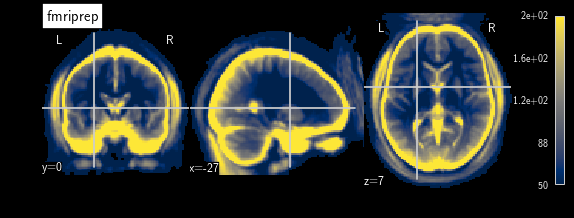

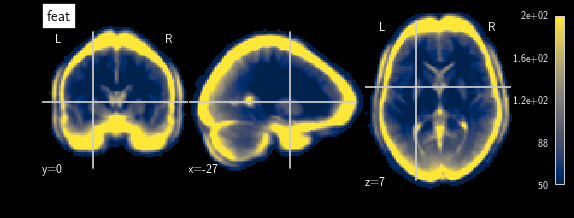

In [19]:
coords = [-27, 0, 7]

thres = 20
vmin = 50
vmax = 200
plotting.plot_anat(str(fprep_std), cut_coords=coords, colorbar=True, cmap='cividis',
                   threshold=thres, vmin=vmin, vmax=vmax, title='fmriprep'
);
plotting.plot_anat(str(feat_std), cut_coords=coords, colorbar=True, cmap='cividis',
                   threshold=thres, vmin=vmin, vmax=vmax, title='feat'
);

In [ ]:
plt.clf()
for i, coords in enumerate([-5, 10, 20]):
    disp = plotting.plot_anat(str(fprep_std), display_mode='z', cut_coords=[coords], cmap='cividis', threshold=30, vmin=50, vmax=170)
    f = plt.gcf().set_size_inches(10, 20)
    disp.add_contours(str(ATLAS_HOME / '1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
    disp.add_contours(str(ATLAS_HOME / '1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], alpha=0.7)
    disp.add_contours(str(ATLAS_HOME / '1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
    plt.savefig(str(Path.home() / 'Dropbox' / 'My Publications' / '2017-FMRIPREP' / 'figures' / ('fmriprep-std-closeup%03d.svg' % i)), format='svg', bbox_inches='tight')

In [ ]:
str(ATLAS_HOME / '1mm_tpm_csf.nii.gz')for i, coords in enumerate([-5, 10, 20]):
    disp = plotting.plot_anat(str(feat_std), display_mode='z', cut_coords=[coords], cmap='viridis', threshold=30, vmin=50, vmax=170)
    f = plt.gcf().set_size_inches(10, 20)
    disp.add_contours(str(ATLAS_HOME / '1mm_tpm_csf.nii.gz'), colors=['k'], levels=[0.8])
    disp.add_contours(str(ATLAS_HOME / '1mm_tpm_wm.nii.gz'), colors=['w'], levels=[0.8], alpha=0.7)
    disp.add_contours(str(ATLAS_HOME / '1mm_brainmask.nii.gz'), colors=['k'], levels=[0.8], linewidths=[3], alpha=.7)
    plt.savefig(os.path.join(work_dir, 'feat-std-closeup%03d.svg' % i), format='svg', bbox_inches='tight')

In [ ]:
disp = plotting.plot_glass_brain(str(feat_std))

In [ ]:
%matplotlib inline
import os
import glob
import warnings; warnings.simplefilter('ignore')
from pathlib import Path

import matplotlib as mpl
mpl.use('pgf')
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
import nibabel as nb
import seaborn as sn
from nilearn import plotting

import pandas as pd
import palettable

pgf_with_custom_preamble = {
    'text.usetex': True,    # use inline math for ticks
    'pgf.rcfonts': False,   # don't setup fonts from rc parameters
    'pgf.texsystem': 'xelatex',
    'verbose.level': 'debug-annoying',
    "pgf.preamble": [
        r"""\usepackage{fontspec}
\setsansfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmainfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmonofont{Inconsolata-dz}
\renewcommand\familydefault{\sfdefault}
""",]
}
mpl.rcParams.update(pgf_with_custom_preamble)

In [ ]:
basedir = derivs_home / 'fmriprep_vs_feat_2.0-oe'
pipelines = ['fslfeat','fmriprep']
subject = 'sub-11090'
home = {'fslfeat': feat_home, 'fmriprep': fprep_home}

In [ ]:
images = {}
bg_images = {}
preptpl = '{0}_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format
for pipeline in pipelines:
    z11 = basedir / subject / 'func' / '{}_task-stopsignal_variant-{}_zstat11.nii.gz'.format(subject, pipeline)
    images[pipeline] = str(z11)
    
    im = nb.load(str(home[pipeline] / subject / 'func' / preptpl(subject)))
    bg_images[pipeline] = nb.Nifti1Image(im.get_data().mean(3), im.affine, im.header)

In [ ]:
for idx, pipeline in enumerate(pipelines):
    plotting.plot_stat_map(images[pipeline], title=pipeline, cmap='RdYlBu_r',
                           colorbar=True,symmetric_cbar=True, alpha=0.6,
                           bg_img=bg_images[pipeline])
plotting.show()

In [ ]:
for idx,pipeline in enumerate(pipelines):
    plotting.plot_glass_brain(images[pipeline],title=pipeline,cmap='RdYlBu_r',
                              colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

In [ ]:
plt.figure(figsize=(10,7))
sn.distplot(nb.load(images['fmriprep']).get_data()[mask2mm], label='fmriprep')
sn.distplot(nb.load(images['fslfeat']).get_data()[mask2mm], label='feat')
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

In [ ]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
   plotting.plot_stat_map(images[pipeline], title=pipeline, vmax=5,
                          display_mode='z', threshold=1.65, cut_coords=cut_coords,
                          bg_img=bg_images[pipeline])
plotting.show()

In [ ]:
# Grab all Z-value maps
fmriprep_z11 = [str(f) for f in basedir.glob('sub-*/func/sub-*_task-stopsignal_variant-fmriprep_zstat11.nii.gz')]
fslfeat_z11 = [str(f) for f in basedir.glob('sub-*/func/sub-*_task-stopsignal_variant-fslfeat_zstat11.nii.gz')]

# Extract values
fmriprep_vals = nb.concat_images(fmriprep_z11).get_data()
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], fmriprep_vals.shape[-1], -1)
fmriprep_vals = fmriprep_vals[mask2mm4d]

feat_vals = nb.concat_images(fslfeat_z11).get_data()
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], feat_vals.shape[-1], -1)
feat_vals = feat_vals[mask2mm4d]

plt.figure(figsize=(10,7))
sn.distplot(fmriprep_vals,label='fmriprep')
sn.distplot(feat_vals,label='feat')
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

In [ ]:
# Grab all T-value maps
fmriprep_t11 = [str(f) for f in basedir.glob('sub-*/func/sub-*_task-stopsignal_variant-fmriprep_tstat11.nii.gz')]
fslfeat_t11 = [str(f) for f in basedir.glob('sub-*/func/sub-*_task-stopsignal_variant-fslfeat_tstat11.nii.gz')]

# Extract values
fmriprep_vals = nb.concat_images(fmriprep_t11).get_data()
feat_vals = nb.concat_images(fslfeat_t11).get_data()

plt.figure(figsize=(10,7))
sn.distplot(fmriprep_vals[mask2mm4d], label='fmriprep')
sn.distplot(feat_vals[mask2mm4d], label='feat')
plt.title("Distribution of T-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

In [ ]:
from shutil import copy
from nipype.algorithms.stats import ACM
acm_feat = ACM(in_files=fslfeat_z11).run().outputs.out_file
copy(acm_feat, str(basedir / 'acm_feat.nii.gz'))
acm_fmriprep = ACM(in_files=fmriprep_z11).run().outputs.out_file
copy(acm_fmriprep, str(basedir / 'acm_fpre.nii.gz'));

In [ ]:
plotting.plot_glass_brain(str(basedir / 'acm_fpre.nii.gz'), 
                          title='fmriprep', vmin=-0.8, vmax=0.8, colorbar=True,
                          cmap='RdYlBu_r', symmetric_cbar=True, plot_abs=False)
plotting.plot_glass_brain(str(basedir / 'acm_feat.nii.gz'), 
                          title='feat', vmin=-0.8, vmax=0.8, colorbar=True,
                          cmap='RdYlBu_r', symmetric_cbar=True, plot_abs=False)
plotting.show()

In [ ]:
plt.clf()
cut_coords = [-15, -8, 6, 30, 46, 62]
plotting.plot_stat_map(str(basedir / 'acm_feat.nii.gz'),
                       title='feat', threshold=0.25, display_mode='z',
                       cut_coords=cut_coords, vmax=0.8, bg_img=atlas)

plotting.plot_stat_map(str(basedir / 'acm_fpre.nii.gz'),
                       title='fmriprep', threshold=0.25, display_mode='z',
                       cut_coords=cut_coords, vmax=0.8, bg_img=atlas)
plotting.show()

In [ ]:
plt.clf()

sn.set_context("notebook", font_scale=1.3)
sn.set_style("whitegrid", {
    'xtick.major.size': 5,
})

cut_coords = [0, 15, 30]

df = pd.read_csv(str(basedir / 'smoothness.csv'))

fig = plt.gcf()
_ = fig.set_size_inches(15, 2 * 3.1)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1],  hspace=0.0, wspace=0.6)

ax3 = plt.subplot(gs[0, :-1])
ax4 = plt.subplot(gs[1, :-1])
ax1 = plt.subplot(gs[0, -1])
ax2 = plt.subplot(gs[1, -1])

disp = plotting.plot_stat_map(str(basedir / 'acm_fpre.nii.gz'), 
                              bg_img=atlas, threshold=0.25, display_mode='z', 
                              cut_coords=cut_coords, vmax=0.8, alpha=0.8,
                              axes=ax1, colorbar=False)
cbar = fig.colorbar(ax1, ticks=[0, 0.275, 0.725, 1.0])
cbar.ax.set_yticklabels([-0.8, -0.25, 0.25, 0.8])
# print(list(fig.axes[-1].get_yticks()))
# fig.axes[-1].set_yticks([0, 0.275, 0.5, 0.725, 1.0])
# print(list(fig.axes[-1].get_yticks()))

plotting.plot_stat_map(str(basedir / 'acm_feat.nii.gz'), 
                       bg_img=atlas, threshold=0.25, display_mode='z', 
                       cut_coords=cut_coords, vmax=0.8, alpha=0.8,
                       axes=ax2, colorbar=False)

ax1.annotate(
    'fMRIPrep',
    xy=(0., .5), xycoords='axes fraction', xytext=(-40, .0),
    textcoords='offset points', va='center', color='k', size=24,
    rotation=90)

ax2.annotate(
    r'\texttt{feat}',
    xy=(0., .5), xycoords='axes fraction', xytext=(-40, .0),
    textcoords='offset points', va='center', color='k', size=24,
    rotation=90)



fmriprep_smooth = df[df.pipeline.str.contains('fmriprep')][['fwhm_pre', 'fwhm_post']]
feat_smooth = df[df.pipeline.str.contains('feat')][['fwhm_pre', 'fwhm_post']]

cols = palettable.tableau.ColorBlind_10.hex_colors
sn.distplot(fmriprep_smooth.fwhm_pre, color=cols[0], ax=ax3,
            axlabel='Smoothing', label='fMRIPrep')
sn.distplot(feat_smooth.fwhm_pre, color=cols[1], ax=ax3,
            axlabel='Smoothing', label=r'\texttt{feat}')

sn.distplot(fmriprep_smooth.fwhm_post, color=cols[0], ax=ax4,
            axlabel='Smoothing', label='fMRIPrep')
sn.distplot(feat_smooth.fwhm_post, color=cols[1], ax=ax4,
            axlabel=r'\noindent\parbox{6.8cm}{\centering\textbf{Estimated smoothness} full~width~half~maximum~(mm)}',
            label='feat')

ax4.set_xlim([3, 8])
ax4.set_xticks([3, 4, 5, 6 , 7, 8])
ax4.set_xticklabels([3, 4, 5, 6 , 7, 8])
ax4.grid(False)

sn.despine(offset=0, trim=True)

ax4.set_ylim([-3, 8])
ax4.set_yticks([])
ax4.spines['left'].set_visible(False)

ax3.set_ylabel(r'\noindent\parbox{4.8cm}{\centering\textbf{Before smoothing} fraction of images}')
ax3.yaxis.set_label_coords(-0.1, 0.4)
ax4.set_ylabel(r'\noindent\parbox{4.8cm}{\centering\textbf{After smoothing} fraction of images}')
ax4.yaxis.set_label_coords(-0.1, 0.5)

# ax4.spines['bottom'].set_position(('outward', 20))
ax4.invert_yaxis()
ax4.xaxis.set_label_position('top') 
ax4.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(True)
ax4.spines['top'].set_position(('data', 5))
ax4.xaxis.set_ticks_position('top')
ax4.tick_params(axis='x', pad=-30)
ax4.xaxis.set_label_coords(0.6, 0.85)


ax3.set_xlim([3, 8])
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.set_ylim([0, 11])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.grid(False)
ax3.set_xlabel('')
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

legend = ax3.legend(ncol=2, loc='upper right', bbox_to_anchor=(1.0,0.8))
legend.get_frame().set_facecolor('w')
legend.get_frame().set_edgecolor('gray')

ax3.set_title('A', fontdict={'fontsize': 24}, loc='left');
ax1.set_title('B', fontdict={'fontsize': 24}, loc='left');

plt.savefig(str(Path.home() / 'Dropbox' / 'My Publications' / '2017-FMRIPREP' / 'figures' / 'fmriprep-feat-1stlevel-2.pdf'),
            format='pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)

In [ ]:
fmriprep_t = nb.load(str(basedir.parent / 'l2' / 'fmriprep_stopsignal_N050_R100_S1' / 'tstat1.nii.gz')).get_data()
feat_t = nb.load(str(basedir.parent / 'l2' / 'fslfeat_stopsignal_N050_R100_S1' / 'tstat1.nii.gz')).get_data()

sn.distplot(fmriprep_t[mask2mm],label='fmriprep')
sn.distplot(feat_t[mask2mm],label='feat')
plt.legend()

In [ ]:
cut_coords = [-15, -8, 6, 30, 46, 62]
plotting.plot_stat_map(str(basedir.parent / 'l2' / 'fmriprep_stopsignal_N010_R001_S0' / 'tstat1.nii.gz'),title='fmriprep',threshold=2.98,display_mode='z',cut_coords=cut_coords,vmax=14)
plotting.plot_stat_map(str(basedir.parent / 'l2' / 'fslfeat_stopsignal_N010_R001_S0' / 'tstat1.nii.gz'),title='feat',threshold=2.98,display_mode='z',cut_coords=cut_coords,vmax=14)

In [ ]:
plotting.plot_glass_brain(str(basedir.parent / 'l2' / 'fmriprep_stopsignal_N100_R001_S0' / 'tstat1.nii.gz'),title='fmriprep',cmap='RdYlBu_r',
                          vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.plot_glass_brain(str(basedir.parent / 'l2' / 'fslfeat_stopsignal_N100_R001_S0' / 'tstat1.nii.gz'),title='feat',cmap='RdYlBu_r',
                          vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False)

In [59]:
%matplotlib inline
import pandas as pd

import os
import glob
import warnings; warnings.simplefilter('ignore')
from pathlib import Path

import matplotlib as mpl
mpl.use('pgf')
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
import nibabel as nb
import seaborn as sn
from nilearn import plotting

import pandas as pd
import palettable

pgf_with_custom_preamble = {
    'text.usetex': True,    # use inline math for ticks
    'pgf.rcfonts': False,   # don't setup fonts from rc parameters
    'pgf.texsystem': 'xelatex',
    'verbose.level': 'debug-annoying',
    "pgf.preamble": [
        r"""\usepackage{fontspec}
\setsansfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmainfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmonofont{Inconsolata-dz}
\renewcommand\familydefault{\sfdefault}
""",]
}
mpl.rcParams.update(pgf_with_custom_preamble)

basedir = Path('/oak/stanford/groups/russpold/data/ds000030/1.0.3/derivatives/fmriprep_vs_feat_2.0-oe')


In [60]:
# jokesdf = pd.read_csv(basedir.parent.parent / 'fmriprep_vs_feat' / 'results.csv', index_col=0)
jokesdf = pd.read_csv(basedir.parent / 'fmriprep_vs_feat_2.0-jd' / 'results.csv', index_col=0)
jokesdf.columns = ['IFG', 'PCG', 'STN', 'correlation', 'bdice', 'bdicemasked', 'experiment', 'fdice',
       'fdicemasked', 'pipeline', 'preSMA', 'N']
jokesdf.pipeline = jokesdf.pipeline.str.replace('fslfeat_5.0.10', 'feat')
jokesdf.pipeline = jokesdf.pipeline.str.replace('fmriprep_1.0.8', 'fmriprep')
jokesdf.N = jokesdf.N.astype('uint8')

In [75]:
basedir = Path('/oak/stanford/groups/russpold/data/ds000030/1.0.3/derivatives/fmriprep_vs_feat_2.0-oe')
dataframe = pd.read_csv(basedir / 'l2' / 'group.csv', index_col=0)

<Figure size 432x288 with 0 Axes>

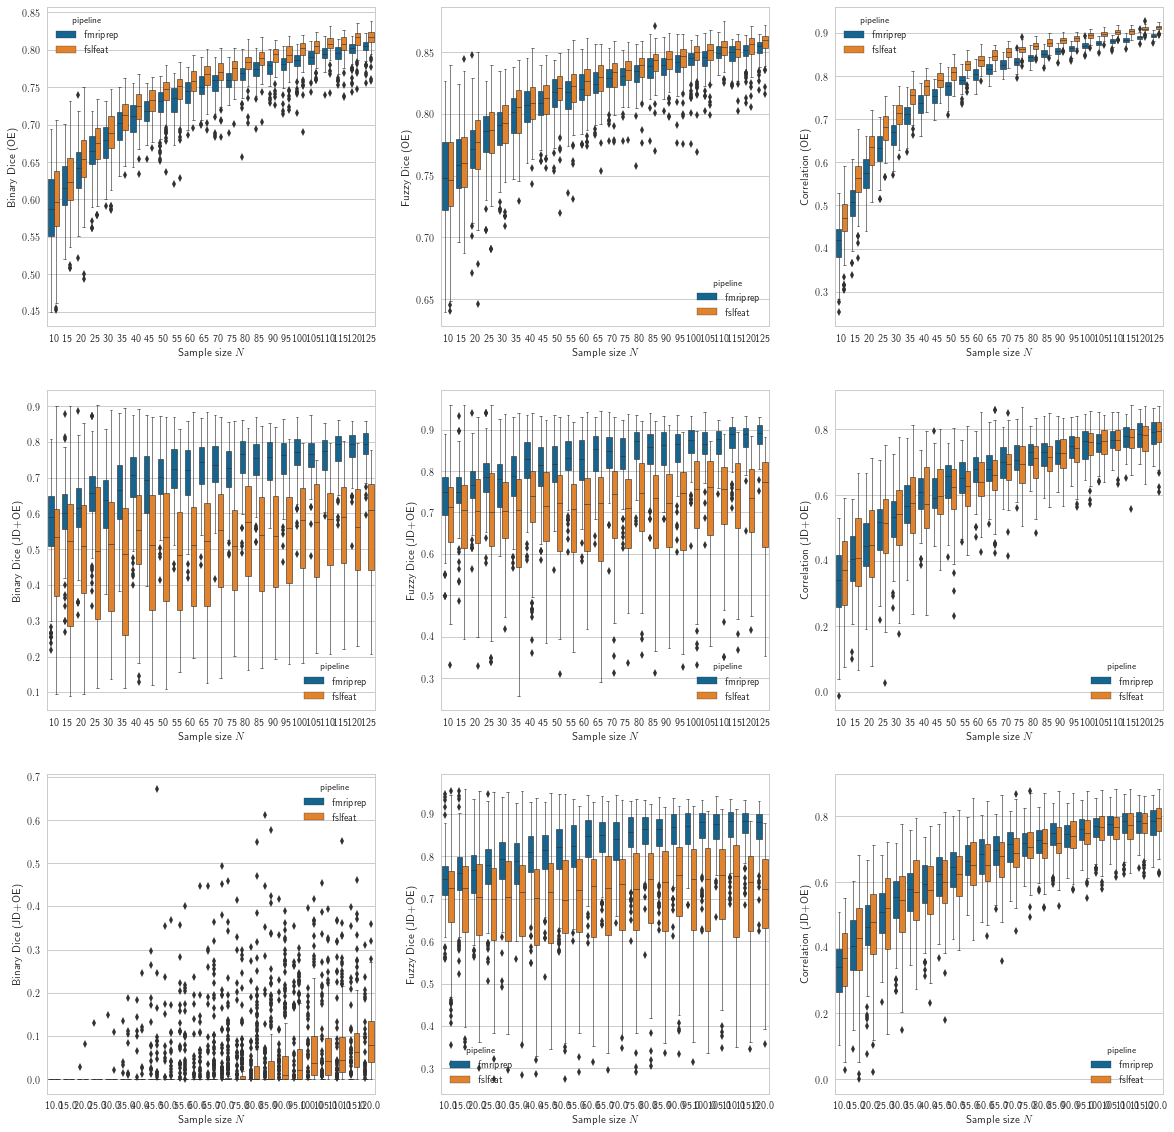

In [76]:
cols = palettable.tableau.ColorBlind_10.hex_colors
sn.set_style("whitegrid")

plt.clf()
fig = plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sn.boxplot(x="N", y="bdice", hue='pipeline', hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=0.6)
# sn.pointplot(x="N", y="bdice", hue="pipeline", data=dataframe,
#              capsize=.2, palette=cols, size=0.5, aspect=.75, dodge=0.5)
plt.ylabel("Binary Dice (OE)")
plt.xlabel("Sample size $N$")

plt.subplot(3,3,2)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
plt.ylabel("Fuzzy Dice (OE)")
plt.xlabel("Sample size $N$")
plt.subplot(3,3,3)
sn.boxplot(x="N", y="correlation", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (OE)")
plt.xlabel("Sample size $N$")


basedir = Path('/oak/stanford/groups/russpold/data/ds000030/1.0.3/derivatives/fmriprep_vs_feat_2.0-jd')
jd1 = pd.read_csv(basedir / 'l2' / 'group.csv', index_col=0)
plt.subplot(3,3,4)
sn.boxplot(x="N", y="bdice", hue='pipeline', hue_order=['fmriprep', 'fslfeat'],
           data=jd1, palette=cols, linewidth=0.6)
# sn.pointplot(x="N", y="bdice", hue="pipeline", data=dataframe,
#              capsize=.2, palette=cols, size=0.5, aspect=.75, dodge=0.5)
plt.ylabel("Binary Dice (JD+OE)")
plt.xlabel("Sample size $N$")

plt.subplot(3,3,5)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=jd1, palette=cols, linewidth=.6)
plt.ylabel("Fuzzy Dice (JD+OE)")
plt.xlabel("Sample size $N$")
plt.subplot(3,3,6)
sn.boxplot(x="N", y="correlation", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=jd1, palette=cols, linewidth=.6)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (JD+OE)")
plt.xlabel("Sample size $N$")



basedir = Path('/oak/stanford/groups/russpold/data/ds000030/1.0.3/derivatives/fmriprep_vs_feat_2.0-jd')
dataframe = pd.read_csv(basedir / 'l2-jd' / 'group.csv', index_col=0)
dataframe.columns = ['IFG', 'N', 'PCG', 'STN', 'correlation', 'bdice-old', 'bdice', 'fdice-old',
                     'fdice', 'pipeline', 'preSMA', 'repetition']
plt.subplot(3,3,7)
sn.boxplot(x="N", y="bdice", hue='pipeline', hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=0.6)
# sn.pointplot(x="N", y="bdice", hue="pipeline", data=dataframe,
#              capsize=.2, palette=cols, size=0.5, aspect=.75, dodge=0.5)
plt.ylabel("Binary Dice (JD+OE)")
plt.xlabel("Sample size $N$")

plt.subplot(3,3,8)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
plt.ylabel("Fuzzy Dice (JD+OE)")
plt.xlabel("Sample size $N$")
plt.subplot(3,3,9)
sn.boxplot(x="N", y="correlation", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (JD+OE)")
plt.xlabel("Sample size $N$")




# fprepdf = dataframe[dataframe.pipeline.str.startswith('fmriprep')]
# featdf = dataframe[dataframe.pipeline.str.contains('feat')]

# samplesizes = sorted(list(set(dataframe.N.values.ravel())))
# fprepstds = [fprepdf[fprepdf.N == s].fdice.mad() for s in samplesizes]
# featstds = [featdf[featdf.N == s].fdice.mad() for s in samplesizes]

# ax.scatter(x=samplesizes, y=fprepstds, color=cols[0])
# ax.scatter(x=samplesizes, y=featstds, color=cols[1])


plt.savefig(str(Path.home() / 'Dropbox' / 'My Publications' / '2017-FMRIPREP' / 'figures' / 'fmriprep-feat-2stlevel-jd_vs_oe.pdf'),
            format='pdf', pad_inches=0.2, dpi=300)

<Figure size 432x288 with 0 Axes>

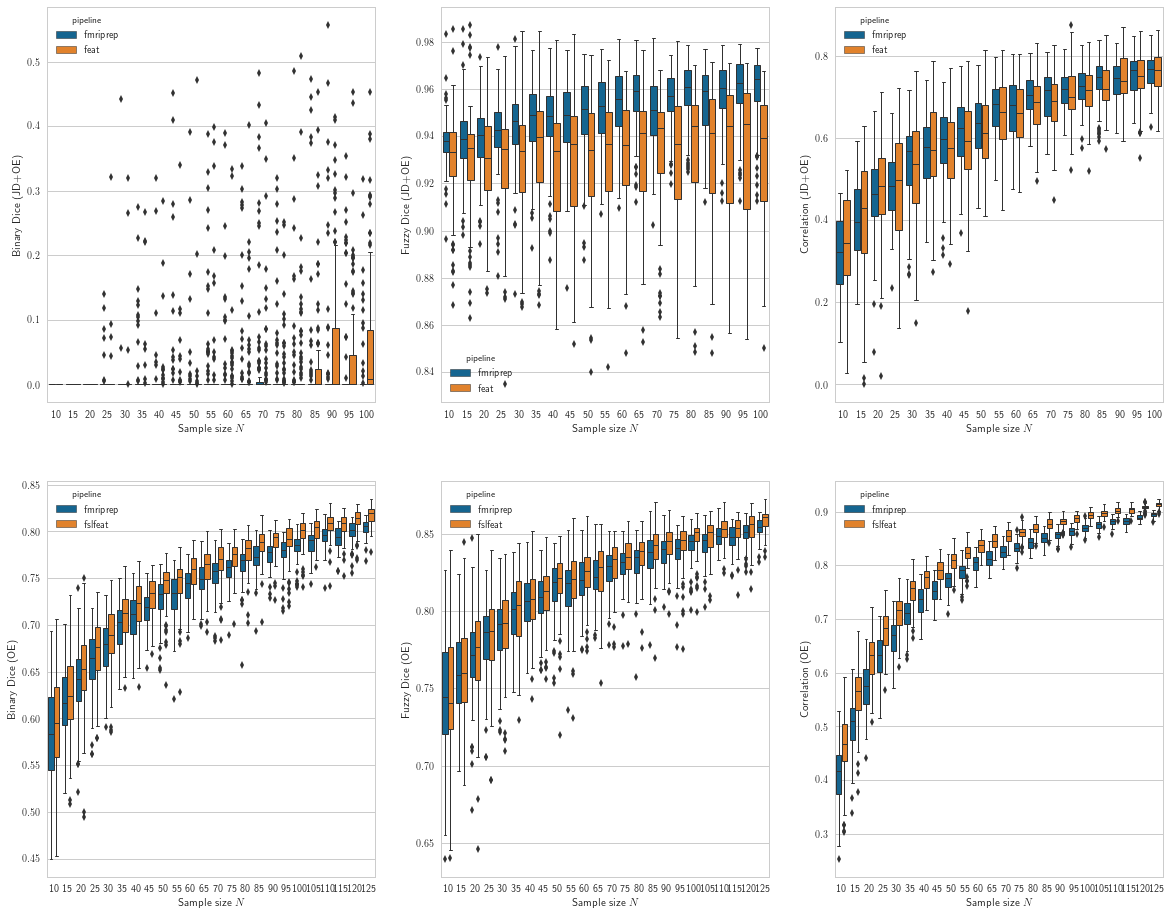

In [27]:
cols = palettable.tableau.ColorBlind_10.hex_colors
sn.set_style("whitegrid")

plt.clf()
fig = plt.figure(figsize=(20,16))

plt.subplot(2,3,1)
# sn.stripplot(x="N", y="bdice", hue="pipeline", data=dataframe, jitter=0.3, alpha=0.5, cmap=cols, size=3)
sn.boxplot(x="N", y="bdice", hue="pipeline", data=jokesdf, palette=cols, linewidth=1)
plt.ylabel("Binary Dice (JD+OE)")
plt.xlabel("Sample size $N$")
plt.subplot(2,3,2)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", data=jokesdf, palette=cols, linewidth=1)
plt.ylabel("Fuzzy Dice (JD+OE)")
plt.xlabel("Sample size $N$")
plt.subplot(2,3,3)
sn.boxplot(x="N", y="correlation", hue="pipeline", data=jokesdf, palette=cols, linewidth=1)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (JD+OE)")
plt.xlabel("Sample size $N$")

# dataframe = pd.read_csv(basedir.parent / 'fmriprep_vs_feat' / 'results.csv', index_col=0)
# dataframe.columns = ['IFG', 'PCG', 'STN', 'correlation', 'bdice', 'experiment', 'fdice',
#        'pipeline', 'preSMA', 'N']
# dataframe.pipeline = dataframe.pipeline.str.replace('fslfeat_5.0.9', 'feat')
# dataframe.pipeline = dataframe.pipeline.str.replace('fmriprep-1.0.3', 'fmriprep')
# dataframe.N = dataframe.N.astype('uint8')

plt.subplot(2,3,4)
# sn.stripplot(x="N", y="bdice", hue="pipeline", data=dataframe, jitter=0.3, alpha=0.5, cmap=cols, size=3)
sn.boxplot(x="N", y="bdice", hue='pipeline', data=dataframe, palette=cols, linewidth=1)
plt.ylabel("Binary Dice (OE)")
plt.xlabel("Sample size $N$")
plt.subplot(2,3,5)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", data=dataframe, palette=cols, linewidth=1)
plt.ylabel("Fuzzy Dice (OE)")
plt.xlabel("Sample size $N$")
plt.subplot(2,3,6)
sn.boxplot(x="N", y="correlation", hue="pipeline", data=dataframe, palette=cols, linewidth=1)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (OE)")
plt.xlabel("Sample size $N$")
plt.savefig(str(Path.home() / 'Dropbox' / 'My Publications' / '2017-FMRIPREP' / 'figures' / 'fmriprep-feat-2stlevel-jd_vs_oe.pdf'),
            format='pdf', pad_inches=0.2, dpi=300)

In [ ]:
%matplotlib inline
cols = palettable.tableau.ColorBlind_10.hex_colors
sn.set_style("whitegrid")

plt.clf()
fig = plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
# sn.stripplot(x="N", y="bdice", hue="pipeline", data=dataframe, jitter=0.3, alpha=0.5, cmap=cols, size=3)
sn.boxplot(x="N", y="bdice", hue="pipeline", data=dataframe, palette=cols, linewidth=1)
plt.ylabel("Binary Dice (OE)")
plt.xlabel("Sample size $N$")
plt.subplot(1,3,2)
# sn.stripplot(x="N", y="fdice", hue="pipeline", data=dataframe)
sn.boxplot(x="N", y="fdice", hue="pipeline", data=dataframe, palette=cols, linewidth=1)
plt.ylabel("Fuzzy Dice (OE)")
plt.xlabel("Sample size $N$")
plt.subplot(1,3,3)
sn.boxplot(x="N", y="correlation", hue="pipeline", data=dataframe, palette=cols, linewidth=1)
# sn.stripplot(x="N", y="correlation", hue="pipeline", data=dataframe)
plt.ylabel("Correlation (OE)")
plt.xlabel("Sample size $N$")